In [26]:
# Import the libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('seaborn-darkgrid')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


C:\Users\Anand Nair\AppData\Local\Temp\ipykernel_12896\2881390761.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Load the data
ticker=input("Enter the Ticker value(AAPL,GOOG etc.): ")
end_date=input("Previous market opening date(YYYY-MM-DD): ")
df = yf.download(ticker, start='2012-01-01', end=end_date)

[*********************100%***********************]  1 of 1 completed


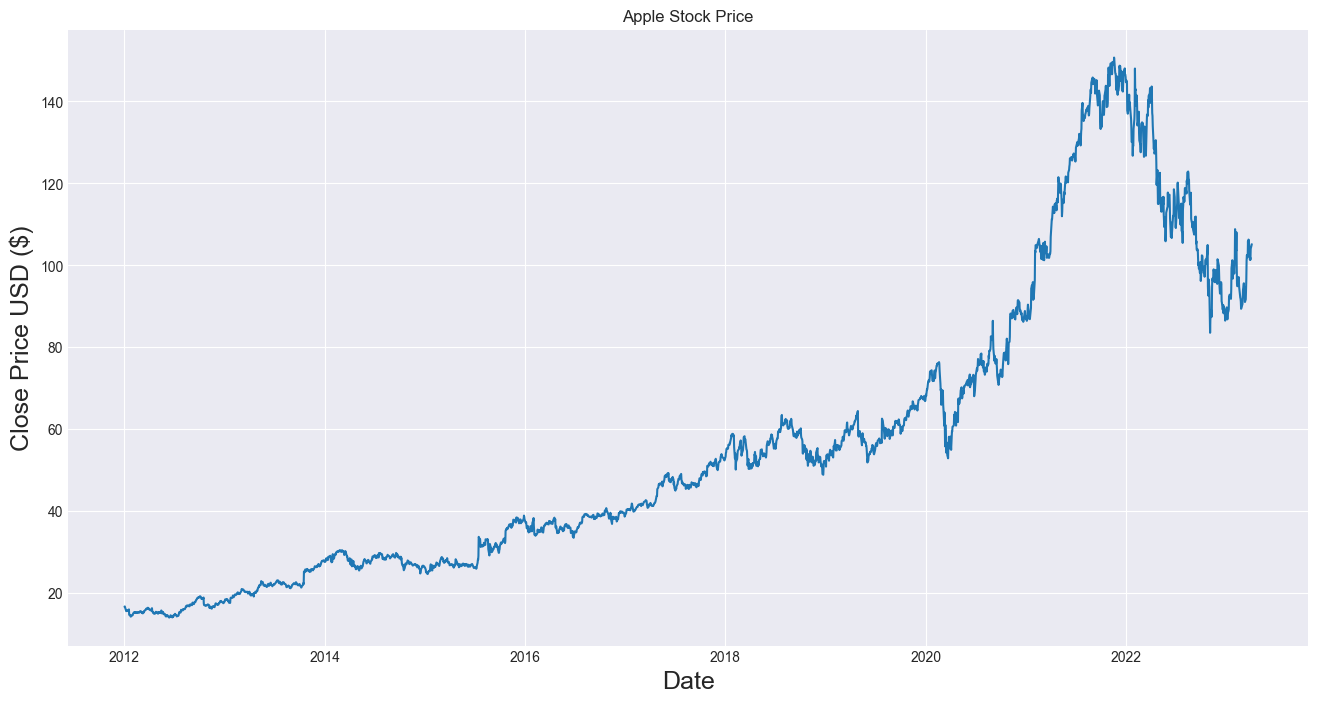

In [3]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Apple Stock Price')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

In [5]:
# Convert the dataframe to a numpy array
dataset = data.values

In [6]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 ))


In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [8]:
# Create the scaled training data
train_data = scaled_data[0:training_data_len, :]


In [9]:
# Split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [10]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [12]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [14]:
# Train the model
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
69/69 [==============================] - 13s 100ms/step - loss: 0.0037
Epoch 2/25
69/69 [==============================] - 9s 132ms/step - loss: 8.3812e-04
Epoch 3/25
69/69 [==============================] - 10s 139ms/step - loss: 7.2778e-04
Epoch 4/25
69/69 [==============================] - 14s 211ms/step - loss: 6.9544e-04
Epoch 5/25
69/69 [==============================] - 31s 449ms/step - loss: 6.8733e-04
Epoch 6/25
69/69 [==============================] - 17s 245ms/step - loss: 5.9306e-04
Epoch 7/25
69/69 [==============================] - 9s 136ms/step - loss: 5.6233e-04
Epoch 8/25
69/69 [==============================] - 11s 167ms/step - loss: 5.1511e-04
Epoch 9/25
69/69 [==============================] - 10s 150ms/step - loss: 5.1867e-04
Epoch 10/25
69/69 [==============================] - 11s 154ms/step - loss: 4.9408e-04
Epoch 11/25
69/69 [==============================] - 10s 138ms/step - loss: 5.3882e-04
Epoch 12/25
69/69 [==============================] - 12s 1

In [15]:
# Save the model
model.save('my_model.h5')

In [16]:
# Create the testing data
test_data = scaled_data[training_data_len - 60: , :]

In [17]:
# Create the x_test and y_test datasets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [18]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [19]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [20]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

18/18 [==============================] - 4s 46ms/step


In [21]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 4.209659669954


In [22]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\Anand Nair\AppData\Local\Temp\ipykernel_12896\1606462354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


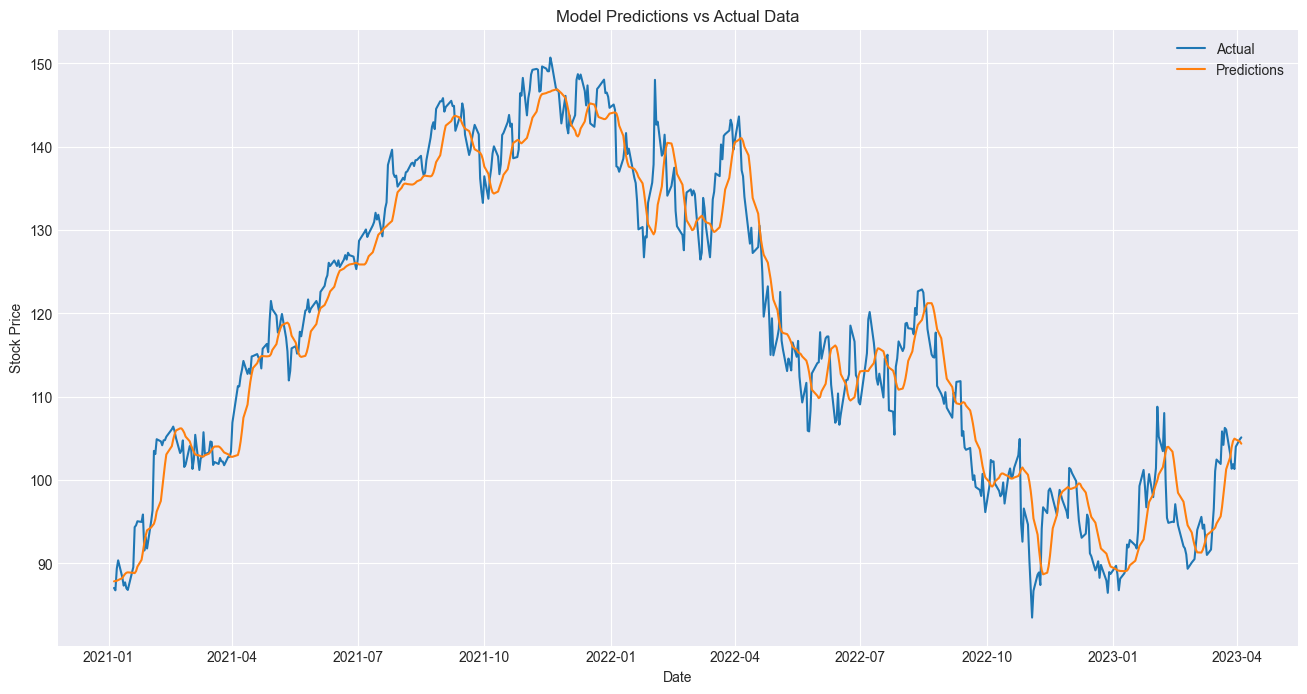

In [23]:
plt.figure(figsize=(16,8))
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.title('Model Predictions vs Actual Data')
plt.legend(['Actual', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()